# RNN for PINN
**idea**: learn an RNN model to predict a state against gt measurements $y$ with a pde regularizer like PINNs. We assume measurements are linearly dependent on state (like Kalman).

$$\dfrac{dx}{dt} = f(t) $$

$$\hat x_i = g(x_{i-1};\theta)$$

$$ \underset{\Theta}{\min}\ ||y_i - g(x_{i-1};\theta) ||^2 + ||\dfrac{d\hat x}{dt_i} - f(t_i) ||^2$$


$$\Theta = \{\theta,B\}$$

In this example the RNN $g$ doesn't handle time input. Possible fix: embed $t$ to the x by augmentation. 

## Report

Critical parameters that seem to alter results significantly are

* testing scenario: train data are from different trajectories (initial velocity and position) of $seq\_len=10$, from $t=t_0$, to $t=t_0+1$. Testing is done with $seq\_len=10$ starting at a $t_1 >> t_0$. Possibly this way of testing could be misleading since the aim is to test whether the RNN captures the dynamics rather than its of data.

* hidden_size
* seq_len
* substitute RNN with linear layer

parameters that are speculated to be critical but seem to not alter results

* rollout: let RNN predict given previous prediction. Repeat for $seq\_len$

In [4]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


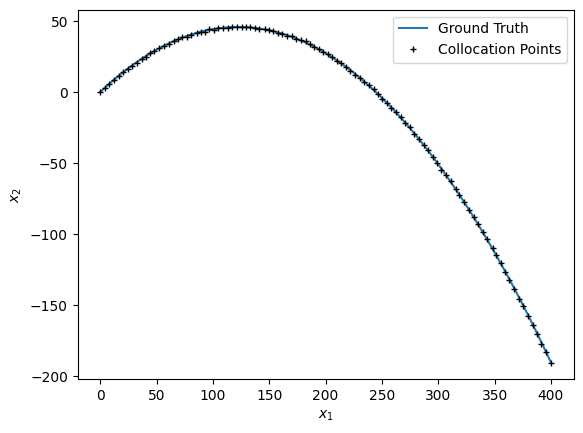

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

""" KNOWN """

def dxdtdt(t): # second derivative of x wrt t
    return torch.tensor([[0], [-9.81]])


""" UNKNOWN """

# unknown x(t)
def x(t, x0=torch.tensor([0, 0]), dxdt0=torch.tensor([40, 30])): # noisy measurements
    t = t.view(-1,1)
    g = torch.tensor([0.0, -9.81]) # acceleration in x,y
    # x0 = torch.tensor([0, 0]) # initial velocities in x,y
    # dxdt0 = torch.tensor([40, 30])
    return (x0 + dxdt0*t + 0.5*g*t**2).T

# Collocation points
t_c = torch.linspace(0, 10, 100)
dt = t_c[1] - t_c[0]
x_c = x(t_c) + torch.randn(2,len(t_c))*0.3

# Plots
t = torch.linspace(0, 10, 100)
x_gt = x(t)
plt.plot(x_gt[0,:], x_gt[1,:], label='Ground Truth')
plt.plot(x_c[0,:].detach().numpy(), x_c[1,:].detach().numpy(), 'k+', markersize=5, label='Collocation Points')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.xlim([0,10])
plt.legend()

# PINN RNN

In [ ]:
import torch.nn as nn


def fetch_batch(batch_size = 32, seq_len = 10, t0 = None):
    """
    Creates a batch of sequences, each with seq_len equi-spaced samples in [t0,t0+1] starting at random (t0,x0) 
    """
    for j in range(batch_size): 
        # time interval [t0,t0+1] within [0,10]
        t0_j = torch.rand(1,).item() * 9 if t0 is None else t0 # random start time in [0,10]
        t = torch.linspace(t0_j, t0_j+1, seq_len)

        # ititial position
        x0 = torch.randn(1,2)

        #initial velocity
        dxdt0 = torch.randn(1,2).abs()*3
        
        # sequence building
        x_j = x(t, x0, dxdt0=dxdt0) #+ torch.randn(2,len(t))*0.3s
        if j == 0:
            x_batch = x_j.T.unsqueeze(1)
            t_batch = t.unsqueeze(1)
        else:
            x_batch = torch.cat((x_batch, x_j.T.unsqueeze(1)), dim=1)
            t_batch = torch.cat((t_batch, t.unsqueeze(1)), dim=1)

    return x_batch, t_batch

class my_rnn(nn.Module):
    def __init__(self):
        """ A simple RNN model to approximate the measurement model """
        super().__init__()
        self.rnn = nn.RNN(input_size=2,
                          hidden_size=2,
                          num_layers=1,
                          nonlinearity='tanh',
                          bias=True,
                          batch_first=False,
                          dropout=0.0,
                          bidirectional=False,
                          device=None,
                          dtype=None)
        # self.rnn = nn.GRU(input_size=2, hidden_size=2, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, device=None, dtype=None)
        # self.rnn = nn.LSTM(input_size=2, hidden_size=2, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, device=None, dtype=None)
        
        self.linear = nn.Linear(self.rnn.hidden_size+self.rnn.input_size, self.rnn.input_size) # overwrite the tanh to escape [-1,1]
        # self.linear = nn.Linear(self.rnn.hidden_size, self.rnn.input_size)
        
        self.NUM_EPOCHS = 10000
        self.LR = 1e-3 

    def forward(self,x):
        s_pred, _ = self.rnn(x)
        if len(x.shape) == 2: # if batched
            s_pred = s_pred.unsqueeze(1)
            x = x.unsqueeze(1)
        # s_pred = self.linear(s_pred)
        s_pred = self.linear(torch.cat((s_pred,x),dim=2))
        return s_pred

g = my_rnn()

loss_fn = nn.MSELoss()  # Use MSE loss with no reduction to calculate loss for each sequence

optimizer = torch.optim.Adam(g.parameters(), lr=g.LR)
g.train()
for epoch in range(1, g.NUM_EPOCHS+1):
    optimizer.zero_grad()

    x_batch,_ = fetch_batch()  # Fetch a batch of collocation sequences

    input =  x_batch[:-1, :, :]  # Reshape (seq_len, batch_size, input_dim)
    target = x_batch[1:, :, :]  # Reshape (seq_len, batch_size, output_dim)

    # identity mapping for input and target
    # input =  x_batch
    # target = x_batch

    if epoch % (g.NUM_EPOCHS*.05) != 0:
        # train normally
        x_pred = g(input) # Reshape output to (batch_size, seq_len, output_dim)
    else:
        # train on rollout
        x_j = input[0,:,:].unsqueeze(0)  # Initialize 
        x_pred = g(x_j)
        # Rollout for 10 time steps
        for _ in range(input.shape[0]-1):
            x_pred_j = g(x_j)
            x_pred = torch.cat((x_pred, x_pred_j), dim=0)  # Rollout one time step
            x_j = x_pred_j
        print('rollout done')

    # use batching in loss calculation
    loss = loss_fn(x_pred.permute(1, 0, 2), target.permute(1, 0, 2))


    # TODO: PINN loss
    # loss = 0.0
    # x_pred = torch.zeros(1,len(t_c)-1,2) # to store the predicted x values
    # for i, t_c_i in enumerate(t_c[:-1], start=1):
    #     x_i = g(input[:,i-1,:])[0].T # g approximates the measurement model
    #     # dxdt_i = torch.zeros(2,1)
    #     # dxdtdt_i = torch.zeros(2,1)
    #     # dxdt_i[0] = torch.autograd.grad(x_i[0].squeeze(), t_c_i, create_graph=True)[0]
    #     # dxdt_i[1] = torch.autograd.grad(x_i[1].squeeze(), t_c_i, create_graph=True)[0]
    #     # dxdtdt_i[0] = torch.autograd.grad(dxdt_i[0].squeeze(), t_c_i, create_graph=True)[0]
    #     # dxdtdt_i[1] = torch.autograd.grad(dxdt_i[1].squeeze(), t_c_i, create_graph=True)[0]
    #     loss += loss_fn(x_i, target[:,i,:]) #+ loss_fn(dxdtdt_i, dxdtdt(t_c_i)))/len(t_c)
    #     x_pred[:,i,:] = x_i.T.detach()

    loss.backward()
    optimizer.step()

    if epoch % (g.NUM_EPOCHS*.05) == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')
#        plt.figure(1)
#         for i in range(x_batch.shape[1]):
#             plt.scatter(x_batch[0,i,0].detach().numpy().item(), x_batch[0,i,1].detach().numpy().item())

rollout done
Epoch: 500, Loss: 17410.26171875
rollout done
Epoch: 1000, Loss: 13320.15625
rollout done
Epoch: 1500, Loss: 12829.943359375
rollout done
Epoch: 2000, Loss: 4026.8046875
rollout done
Epoch: 2500, Loss: 2053.1923828125
rollout done
Epoch: 3000, Loss: 568.334716796875
rollout done
Epoch: 3500, Loss: 547.483642578125
rollout done
Epoch: 4000, Loss: 462.51171875
rollout done
Epoch: 4500, Loss: 203.29209899902344
rollout done
Epoch: 5000, Loss: 259.85504150390625
rollout done
Epoch: 5500, Loss: 195.62939453125
rollout done
Epoch: 6000, Loss: 118.78838348388672
rollout done
Epoch: 6500, Loss: 126.74581146240234
rollout done
Epoch: 7000, Loss: 90.99898529052734
rollout done
Epoch: 7500, Loss: 69.75572204589844
rollout done
Epoch: 8000, Loss: 58.57876205444336
rollout done
Epoch: 8500, Loss: 97.55245971679688
rollout done
Epoch: 9000, Loss: 46.63731002807617
rollout done
Epoch: 9500, Loss: 45.40098571777344
rollout done
Epoch: 10000, Loss: 46.30796813964844


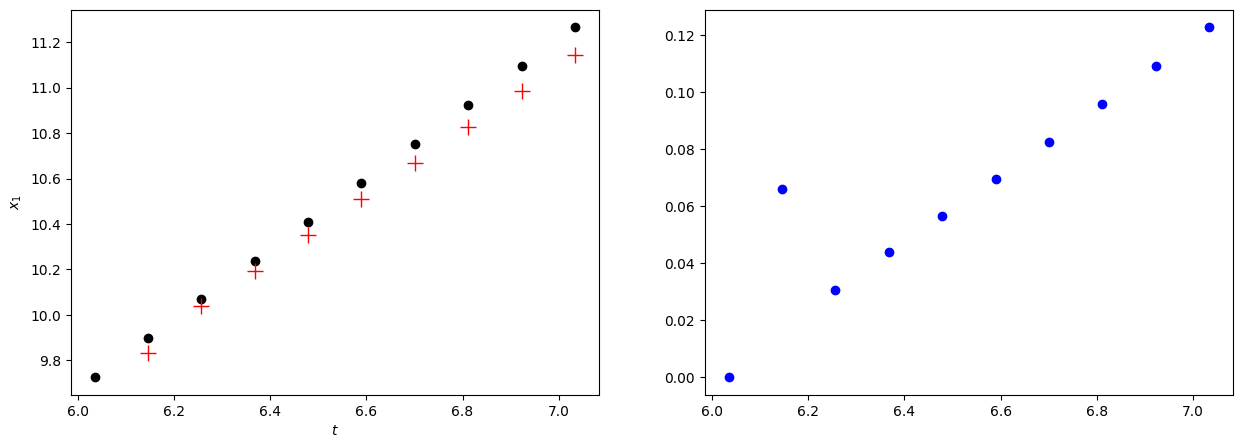

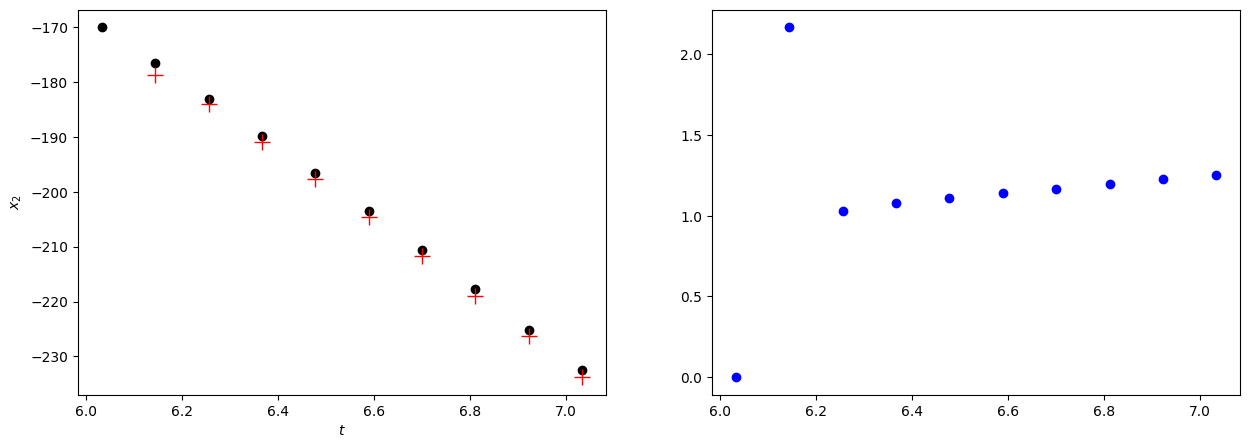

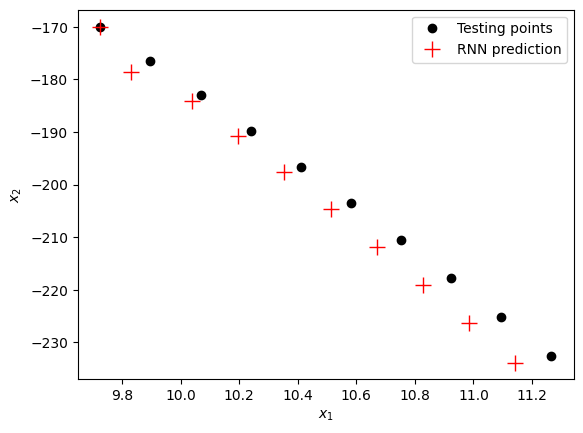

In [143]:
# custom t0
# t0 = 11
# seq_len = 10
# t_test = torch.linspace(t0, t0+1, seq_len)

x_test,t_test = fetch_batch(batch_size=1)

input =  x_test[:-1, :, :]
target = x_test
g.eval()
x_pred = g(input)  # Add batch dimension

# prepend with ground truth to match target length
x_pred = torch.cat((target[[0],:,:], x_pred), dim=0)

x_pred = x_pred.detach().numpy()
target = target.detach().numpy()

import time
save = False
plt.figure(1,figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(t_test, target[:,:,0], 'k.', markersize=12)
plt.plot(t_test[1:], x_pred[1:,:,0], 'r+', markersize=12)
plt.xlabel('$t$')
plt.ylabel(
    '$x_1$')
plt.subplot(1,2,2)
plt.plot(t_test, np.abs(target[:,:,0]-x_pred[:,:,0]), 'b.', markersize=12,label='Error')
if save:
    plt.savefig('pinn_rnn_min_example_x1'+time.strftime('%Y-%m-%d %H:%M:%S')+'.png')

plt.figure(2,figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(t_test, target[:,:,1], 'k.',markersize=12)
plt.plot(t_test[1:], x_pred[1:,:,1], 'r+', markersize=12)
plt.xlabel('$t$')
plt.ylabel('$x_2$')
plt.subplot(1,2,2)
plt.plot(t_test, np.abs(target[:,:,1]-x_pred[:,:,1]), 'b.', markersize=12,label='Error')
if save:
    plt.savefig('pinn_rnn_min_example_x2'+time.strftime('%Y-%m-%d %H:%M:%S')+'.png')

plt.figure(4)
plt.plot(target[:,:,0], target[:,:,1], 'k.', markersize=12)
plt.plot(x_pred[:,:,0], x_pred[:,:,1], 'r+', markersize=12)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(['Testing points','RNN prediction'])
if save:
    plt.savefig('pinn_rnn_min_example_x1x2'+time.strftime('%Y-%m-%d %H:%M:%S')+'.png')